In [122]:
#import standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

This part of the code contains the functions used later on

In [124]:
def compute_player_pa_and_bf(df_players, at_bat_ids, df_savant):
    """
    Computes and adds key baseball statistics for batters and pitchers, including:
    - Total plate appearances (PA) per batter per year.
    - Total batters faced (BF) per pitcher per year.
    - Number of times a base-running event ended an inning.

    The function modifies df_players by merging these computed statistics.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player information, including player IDs and years.
    at_bat_ids : pandas.DataFrame
        DataFrame containing at-bat events with batter, pitcher, and year identifiers.
    df_savant : pandas.DataFrame
        Baseball Savant dataset containing detailed play-by-play event data.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with the following new columns:
        - 'total_pa': Total plate appearances per batter per year.
        - 'total_bf': Total batters faced per pitcher per year.
        - 'base_ended_inn': Count of plate appearances ending due to pickoffs or caught stealing.
    
    Notes:
    ------
    - The function ensures missing values are filled with 0 before merging.
    - Plate appearances that ended due to certain basepath outs (e.g., pickoffs, caught stealing)
      with two outs are subtracted from the total plate appearances.
    """

    # Count total plate appearances for each batter per year
    pa_counts = at_bat_ids.groupby(['batter', 'year'])['at_bat_id'].nunique().reset_index(name='total_pa')
    df_players = df_players.merge(pa_counts, left_on=['player_mlb_id', 'year'], right_on=['batter', 'year'], how='left').drop(columns='batter')
    df_players['total_pa'] = df_players['total_pa'].fillna(0).astype(int)

    # Count total batters faced for each pitcher per year
    bf_counts = at_bat_ids.groupby(['pitcher', 'year'])['at_bat_id'].nunique().reset_index(name='total_bf')
    df_players = df_players.merge(bf_counts, left_on=['player_mlb_id', 'year'], right_on=['pitcher', 'year'], how='left').drop(columns='pitcher')
    df_players['total_bf'] = df_players['total_bf'].fillna(0).astype(int)

    # Define basepath outs that result in an out
    basepath_outs = [
        'caught_stealing_3b', 'caught_stealing_2b', 'pickoff_caught_stealing_2b', 'pickoff_2b',
        'pickoff_caught_stealing_3b', 'pickoff_1b', 'caught_stealing_home', 'pickoff_3b', 'pickoff_caught_stealing_home'
    ]

    # Filter for basepath events that ended an inning (2 outs when the event occurred)
    df_basepath_ends_inning = df_savant[(df_savant['outs_when_up'] == 2) & (df_savant['events'].isin(basepath_outs))]
    count_basepath_ended_ab = df_basepath_ends_inning.groupby(['batter', 'year'])['at_bat_id'].nunique().reset_index(name='base_ended_inn')

    # Merge basepath-ended inning counts and adjust plate appearances
    df_players = df_players.merge(count_basepath_ended_ab, left_on=['player_mlb_id', 'year'], right_on=['batter', 'year'], how='left').drop(columns='batter')
    df_players['base_ended_inn'] = df_players['base_ended_inn'].fillna(0).astype(int)
    df_players['total_pa'] = df_players['total_pa'] - df_players['base_ended_inn']

    return df_players


In [125]:
def get_fielding_counts(df_players, df_savant):
    """
    Computes and adds fielding appearance counts for each player at every defensive position per year.

    This function extracts fielding data from the Baseball Savant dataset, counts the number of 
    at-bats where a player appeared at each position, and merges these counts into the player dataset.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player information, including player IDs and years.
    df_savant : pandas.DataFrame
        Baseball Savant dataset containing at-bat-level fielding data.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with additional columns representing the number of fielding appearances 
        at each defensive position per year. New columns follow the format:
        - 'field_p'  : Appearances as a pitcher
        - 'field_c'  : Appearances as a catcher
        - 'field_1b' : Appearances as a first baseman
        - 'field_2b' : Appearances as a second baseman
        - 'field_3b' : Appearances as a third baseman
        - 'field_ss' : Appearances as a shortstop
        - 'field_lf' : Appearances as a left fielder
        - 'field_cf' : Appearances as a center fielder
        - 'field_rf' : Appearances as a right fielder
    """
    
    #get the fielders for every at bat
    df_savant_fielding = df_savant[['at_bat_id','year','pitcher_1',
        'fielder_2_1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
        'fielder_7', 'fielder_8', 'fielder_9']].drop_duplicates()

    #list of each position column name
    fielding_columns = ['pitcher_1', 'fielder_2_1', 'fielder_3', 
                        'fielder_4', 'fielder_5', 'fielder_6',
                        'fielder_7', 'fielder_8', 'fielder_9']
    
    #dictionary to change position column to more recognizable name
    fielding_dict = {'pitcher_1':'p', 'fielder_2_1':'c', 'fielder_3':'1b', 
                     'fielder_4':'2b', 'fielder_5':'3b', 'fielder_6':'ss',
                     'fielder_7':'lf', 'fielder_8':'cf', 'fielder_9':'rf'}
    
    #get count for every player at every position
    for col in fielding_columns:
        col_name = 'field_' + fielding_dict[col]
        count_df = df_savant_fielding.groupby([col, 'year']).size().reset_index(name=col_name)
        
        #add count to main dataframe
        df_players = df_players.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[col, 'year']).drop(columns=col)
        
        #fill NaN with 0
        df_players[col_name] = df_players[col_name].fillna(0).astype(int)

    return df_players

In [126]:
def get_count_for_play_event(df_player, df_sav, event, player_type):
    """
    Computes the number of occurrences of a specific baseball event for each player in a given year 
    and adds the count as a new column to the player dataframe.

    Parameters:
    -----------
    df_player : pandas.DataFrame
        DataFrame containing player information, including player IDs and years.
    df_sav : pandas.DataFrame
        Baseball Savant dataset containing event details.
    event : str
        The specific event to count (e.g., 'home_run', 'strikeout').
    player_type : str
        Specifies whether to filter data by 'batter' or 'pitcher' statistics.

    Returns:
    --------
    pandas.DataFrame
        The input df_player with an additional column representing the count of the specified event 
        for each player per year.
    """
    
    #filter to specified event
    df_filter = df_sav[df_sav['events'] == event]

    #get event count for every batter/year combo
    col_name = player_type + '_' + event
    count_df = df_filter.groupby([player_type, 'year']).size().reset_index(name=col_name)

    #add column to main dataframe
    df_player = df_player.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[player_type, 'year']).drop(columns=player_type)
    df_player[col_name] = df_player[col_name].fillna(0).astype(int)

    return df_player

    #df_players = df_players.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[col, 'year']).drop(columns=col)

    

In [127]:
def calculate_all_play_event_counts(df_players,df_savant):
    """
    Calculates the count of various baseball play events for each player, 
    both as a batter and as a pitcher, and adds these counts to the player DataFrame.

    This function iterates over a predefined list of play events, computes the number 
    of times each event occurred for every player per season, and appends these counts 
    to df_players. Counts are calculated separately for when the player is batting and pitching.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player information, including player IDs and years.
    df_savant : pandas.DataFrame
        Baseball Savant dataset containing detailed event data for each play.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with additional columns for each play event. 
        Columns follow the format:
        - 'batter_<event>': Count of event occurrences when the player is batting.
        - 'pitcher_<event>': Count of event occurrences when the player is pitching.
    """
    
    #list of all non NaN df_savant events
    play_events = ['strikeout', 'caught_stealing_3b', 'field_out', 'walk',
           'force_out', 'sac_fly', 'single', 'hit_by_pitch', 'double',
           'grounded_into_double_play', 'sac_bunt', 'home_run',
           'fielders_choice', 'field_error', 'other_out',
           'caught_stealing_2b', 'triple', 'strikeout_double_play',
           'fielders_choice_out', 'double_play', 'sac_fly_double_play',
           'catcher_interf', 'pickoff_caught_stealing_2b', 'pickoff_2b',
           'pickoff_caught_stealing_3b', 'triple_play', 'pickoff_1b',
           'sac_bunt_double_play', 'wild_pitch', 'game_advisory',
           'caught_stealing_home', 'pickoff_3b', 'stolen_base_2b',
           'passed_ball', 'pickoff_caught_stealing_home', 'pickoff_error_3b',
           'stolen_base_3b']
    
    #get the counts per season for every player
    for event in play_events:
        #calculate the count when player batting
        df_players = get_count_for_play_event(df_players, df_savant, event, 'batter')
        #calculate the count when player pitching
        df_players = get_count_for_play_event(df_players, df_savant, event, 'pitcher')

    return df_players


In [128]:
def calculate_batting_stats(df_players):
    """
    Computes key batting statistics for each player based on event counts from play-by-play data.

    This function calculates various advanced and traditional batting metrics using player-level 
    event data, adding them as new columns to the df_players DataFrame.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player event counts, including hits, plate appearances, strikeouts, 
        walks, home runs, and fielding appearances.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with additional columns for batting statistics
    """
    
    # Calculate new baseball stats
    # Hits (already calculated)
    df_players['hits'] = df_players['batter_single'] + df_players['batter_double'] + df_players['batter_triple'] + df_players['batter_home_run']
    
    # Eligible plate appearances
    df_players['elig_pa'] = df_players['total_pa'] - df_players['batter_sac_fly'] - df_players['batter_sac_bunt'] - df_players['batter_walk'] - df_players['batter_hit_by_pitch']
    
    # Batting Average (AVG)
    df_players['avg'] = df_players['hits'] / df_players['elig_pa']
    
    # Total Bases (TB)
    df_players['tb'] = df_players['batter_single'] + 2 * df_players['batter_double'] + 3 * df_players['batter_triple'] + 4 * df_players['batter_home_run']
    
    # Slugging Percentage (SLG)
    df_players['slg'] = df_players['tb'] / df_players['elig_pa']
    
    # On-Base Percentage (OBP)
    df_players['obp'] = (df_players['hits'] + df_players['batter_walk'] + df_players['batter_hit_by_pitch']) / (df_players['total_pa'])
                                                                                                                
    # On-Base Plus Slugging (OPS)
    df_players['ops'] = df_players['obp'] + df_players['slg']
    
    # Weighted On-Base Average (wOBA) - simplified
    df_players['woba'] = (
        0.69 * df_players['batter_walk'] +
        0.72 * df_players['batter_hit_by_pitch'] +
        0.89 * df_players['batter_single'] +
        1.27 * df_players['batter_double'] +
        1.62 * df_players['batter_triple'] +
        2.10 * df_players['batter_home_run']
    ) / df_players['total_pa']
    
    # Batting Average on Balls in Play (BABIP)
    df_players['babip'] = (
        df_players['hits'] - df_players['batter_home_run']
    ) / (
        df_players['elig_pa']
    )
    
    # Strikeout Rate (K%)
    df_players['k_rate'] = df_players['batter_strikeout'] / df_players['elig_pa']
    
    # Walk Rate (BB%)
    df_players['bb_rate'] = df_players['batter_walk'] / df_players['elig_pa']
    
    # Home Run Rate (HR%)
    df_players['hr_rate'] = df_players['batter_home_run'] / df_players['elig_pa']
    
    # Isolated Power (ISO)
    df_players['iso'] = df_players['slg'] - df_players['avg']
    
    # Extra Base Hits (XBH)
    df_players['xbh'] = df_players['batter_double'] + df_players['batter_triple'] + df_players['batter_home_run']
    
    # Runs Created (RC) - simplified
    df_players['rc'] = (df_players['hits'] + df_players['batter_walk']) * df_players['tb'] / df_players['elig_pa']
    
    # Plate Appearances Per Strikeout (PA/K)
    df_players['pa_per_k'] = df_players['elig_pa'] / df_players['batter_strikeout']
    
    # Plate Appearances Per Walk (PA/BB)
    df_players['pa_per_bb'] = df_players['elig_pa'] / df_players['batter_walk']
    
    # Defensive Versatility (Number of Positions Played)
    df_players['positions_played'] = df_players[['field_p', 'field_c', 'field_1b', 'field_2b', 'field_3b', 
                                                 'field_ss', 'field_lf', 'field_cf', 'field_rf']].gt(0).sum(axis=1)

    return df_players

In [129]:
def calculate_pitching_stats(df_players):
    """
    Computes key pitching statistics for each player based on event counts from play-by-play data.

    This function calculates various advanced and traditional pitching metrics using player-level 
    event data, adding them as new columns to the df_players DataFrame.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing pitcher event counts, including batters faced, strikeouts, walks, 
        and various pitching outcomes.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with additional columns for pitching statistics.
    """

    # Hits allowed (singles, doubles, triples, home runs)
    df_players['pitcher_hits_allowed'] = (df_players['pitcher_single'] + 
                                          df_players['pitcher_double'] + 
                                          df_players['pitcher_triple'] + 
                                          df_players['pitcher_home_run'])

    # Earned Run Average (ERA) - not directly calculable with given data, but proxy metric
    df_players['era_proxy'] = df_players['pitcher_home_run'] / df_players['total_bf']

    # Walks and Hits per Inning Pitched (WHIP) - using batters faced as a proxy for innings
    df_players['whip_proxy'] = (df_players['pitcher_walk'] + df_players['pitcher_hits_allowed']) / df_players['total_bf']

    # Strikeouts per Batter Faced (K%)
    df_players['k_rate'] = df_players['pitcher_strikeout'] / df_players['total_bf']

    # Walk Rate (BB%)
    df_players['bb_rate'] = df_players['pitcher_walk'] / df_players['total_bf']

    # Home Run Rate (HR%)
    df_players['hr_rate'] = df_players['pitcher_home_run'] / df_players['total_bf']

    # Batting Average Against (BAA)
    df_players['baa'] = df_players['pitcher_hits_allowed'] / df_players['total_bf']

    # Ground Ball Rate (GB%) - assuming field_out and force_out are mostly ground balls
    df_players['gb_rate'] = (df_players['pitcher_field_out'] + df_players['pitcher_force_out']) / df_players['total_bf']

    # Fly Ball Rate (FB%) - assuming sac fly and doubles/triples are often fly balls
    df_players['fb_rate'] = (df_players['pitcher_sac_fly'] + 
                             df_players['pitcher_double'] + 
                             df_players['pitcher_triple']) / df_players['total_bf']

    # Strikeout-to-Walk Ratio (K/BB)
    df_players['k_bb_ratio'] = df_players['pitcher_strikeout'] / df_players['pitcher_walk']

    return df_players


In [130]:
def add_to_df_players(df_players, df_savant, at_bat_ids):
    """
    Enhances the df_players DataFrame by computing and adding various performance statistics 
    based on player event data from df_savant and at_bat_ids.

    This function:
    - Filters out players without an MLB ID.
    - Computes the number of years since a player’s MLB debut.
    - Aggregates plate appearance (PA) and batters faced (BF) counts.
    - Tracks fielding appearances at different positions.
    - Counts the occurrences of various play events (e.g., hits, strikeouts, walks).
    - Computes key batting statistics like batting average, slugging, and on-base percentage.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player-level information, including player IDs and debut years.
    df_savant : pandas.DataFrame
        Baseball Savant event-level data, which includes play-by-play information.
    at_bat_ids : pandas.DataFrame
        DataFrame containing unique at-bat identifiers for each play.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with additional columns
    """
    
    #remove players without an mlb Id
    df_players = df_players[df_players['player_mlb_id'].notna()]

    #calculate years since a player debuted
    df_players['years_after_debut'] = df_players['year'] - df_players['debut'].str[-4:].astype(int)

    #get the counts for the main dataframe
    df_players = compute_player_pa_and_bf(df_players, at_bat_ids, df_savant)

    #calculate where a player played in the field 
    df_players = get_fielding_counts(df_players, df_savant)

    #count how many of each stat a player had on the year
    df_players = calculate_all_play_event_counts(df_players,df_savant)

    #calculate batting stats
    df_players = calculate_batting_stats(df_players)

    #calculate pitching stats
    df_players = calculate_pitching_stats(df_players)

    return df_players

Past the functions

In [132]:
#read the csvs as dataframes
df_savant_raw = pd.read_csv('savant_data_2021_2023.csv')
df_people = pd.read_csv('lahman_people.csv')

In [133]:
# #clean Savant data

#convert game date to datetime column
df_savant_raw['game_date'] = pd.to_datetime(df_savant_raw['game_date'])

#create column for year
df_savant_raw['year'] = df_savant_raw['game_date'].dt.year

#create dataframe for each at bat
at_bat_ids = df_savant_raw[['batter','pitcher','game_date','year','times_faced']].drop_duplicates()

#assign a unique id to each at bat
at_bat_ids['at_bat_id'] = range(1, len(at_bat_ids) + 1)

#add unique ids to original savant data
df_savant = df_savant_raw.merge(at_bat_ids, on=['batter','pitcher','game_date','year','times_faced'],how='inner')

In [134]:
df_savant['events'].unique()

array(['strikeout', nan, 'caught_stealing_3b', 'field_out', 'walk',
       'force_out', 'sac_fly', 'single', 'hit_by_pitch', 'double',
       'grounded_into_double_play', 'sac_bunt', 'home_run',
       'fielders_choice', 'field_error', 'other_out',
       'caught_stealing_2b', 'triple', 'strikeout_double_play',
       'fielders_choice_out', 'double_play', 'sac_fly_double_play',
       'catcher_interf', 'pickoff_caught_stealing_2b', 'pickoff_2b',
       'pickoff_caught_stealing_3b', 'triple_play', 'pickoff_1b',
       'sac_bunt_double_play', 'wild_pitch', 'game_advisory',
       'caught_stealing_home', 'pickoff_3b', 'stolen_base_2b',
       'passed_ball', 'pickoff_caught_stealing_home', 'pickoff_error_3b',
       'stolen_base_3b'], dtype=object)

In [135]:
#create dataframe for player season info
df_players = pd.concat([df_people.assign(year=i) for i in range(2021, 2024)], ignore_index=True)

In [136]:
#add columns to df_players based on the Savant data
df_players_full = add_to_df_players(df_players, df_savant, at_bat_ids)

C:\Users\etien\AppData\Local\Temp\ipykernel_18956\1111389796.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players['years_after_debut'] = df_players['year'] - df_players['debut'].str[-4:].astype(int)


In [137]:
#get savant data for batting splits
df_savant_r = df_savant[df_savant['p_throws'] == 'R']
df_savant_l = df_savant[df_savant['p_throws'] == 'L']

#make df_players for each batting split
df_players_r = add_to_df_players(df_players, df_savant_r, at_bat_ids)
df_players_l = add_to_df_players(df_players, df_savant_l, at_bat_ids)

C:\Users\etien\AppData\Local\Temp\ipykernel_18956\1111389796.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players['years_after_debut'] = df_players['year'] - df_players['debut'].str[-4:].astype(int)
C:\Users\etien\AppData\Local\Temp\ipykernel_18956\1111389796.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players['years_after_debut'] = df_players['year'] - df_players['debut'].str[-4:].astype(int)


In [138]:
df_savant.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'batter', 'pitcher', 'events', 'description', 'zone',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'fielder_2',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher_1',
       'fielder_2_1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
       'woba_value', 'woba_denom', 'babip_value', 'iso_value',
       'launch_speed_angle', 'at_bat_number', 'pitch_number

In [139]:
#export csv for use in other .ipynb
df_players_full.to_csv('df_players.csv')

<Axes: xlabel='total_pa', ylabel='Count'>

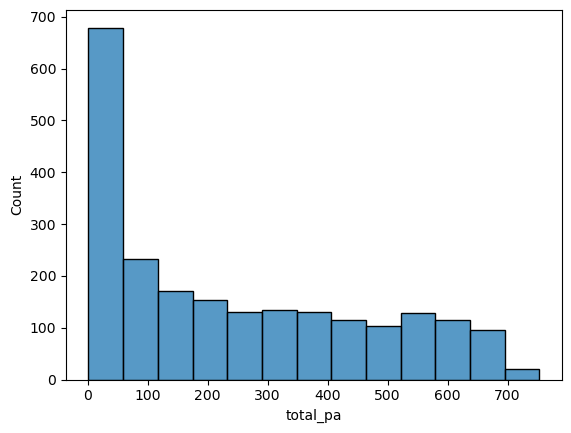

In [140]:
#plot of total plate appearances (min 1). Note this includes pitchers
df_players_with_pa = df_players_full[df_players_full['total_pa'] > 0] 
sns.histplot(df_players_with_pa['total_pa'])

<Axes: xlabel='total_bf', ylabel='Count'>

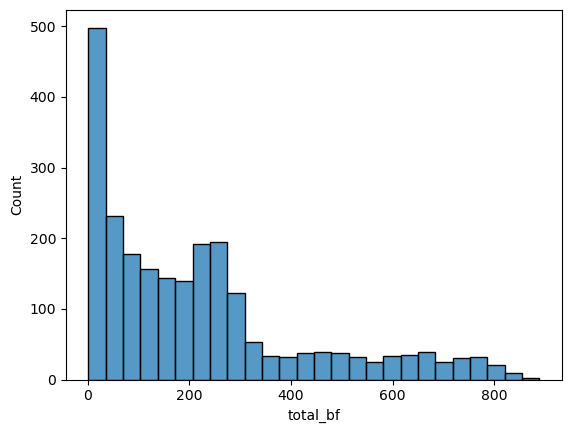

In [141]:
#plot of total batters faced (min 1). Note this includes position players
df_players_with_pa = df_players_full[df_players_full['total_bf'] > 0] 
sns.histplot(df_players_with_pa['total_bf'])

In [142]:
def linear_regression_scatter(df, x, y, min_x=False, min_y=False):
    """
    This function filters out missing values and optionally removes entries that do not meet 
    specified minimum thresholds for the x and y variables. It then fits a simple linear 
    regression model, plots the data points, and overlays the regression line.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset containing the variables to be plotted.
    x : str
        The column name representing the independent variable.
    y : str
        The column name representing the dependent variable.
    min_x : float or bool, optional (default=False)
        The minimum threshold for filtering x values. Entries with x < min_x will be removed.
    min_y : float or bool, optional (default=False)
        The minimum threshold for filtering y values. Entries with y < min_y will be removed.

    Returns: None
    """
    
    #filter entries to where columns aren't null
    df = df[df[x].notnull() & df[y].notnull()]

    #filter out player who do not meet the min
    if min_x != False:
        df = df[df[x] >= min_x]
    
    if min_y != False:
        df = df[df[y] >= min_y]
    
    #get passed columns 
    x_vals = df[x]
    y_vals = df[y]
    
    #perform linear regression
    slope, intercept, r, p, std_err = stats.linregress(x_vals, y_vals)
    
    #define regression function
    def myfunc(x_vals):
        return slope * x_vals + intercept
    
    #generate regression line values
    mymodel = list(map(myfunc, x_vals))
    
    #create scatter plot with regression line
    plt.figure(figsize=(10, 6))  # Increase figure size for better readability
    sns.set_theme(style="whitegrid")  # Use a clean theme
    
    #scatter plot
    sns.scatterplot(x=x_vals, y=y_vals, color="blue", alpha=0.6, s=60, label="Player Data")
    
    #regression line
    plt.plot(x_vals, mymodel, color="red", linewidth=2, label=f"Regression Line (a: {slope:.2f}, b: {intercept:.2f}, R²={r**2:.2f})")
    
    #add text and plot
    plt.title(f"Relationship Between {x} and {y}", fontsize=16)
    plt.xlabel(f"{x}", fontsize=14)
    plt.ylabel(f"{y}", fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

In [146]:
df_players_full.head()

,player_mlb_id,playerID_LAHMAN,birthYear,birthMonth,birthDay,birthCountry,weight,height,bats,throws,...,pa_per_k,pa_per_bb,positions_played,pitcher_hits_allowed,era_proxy,whip_proxy,baa,gb_rate,fb_rate,k_bb_ratio
0,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,L,...,NaN,NaN,1,23,0.012346,0.358025,0.283951,0.432099,0.086420,1.666667
1,33438ca2fdf93ff73b2e1bcc5da3058a04cf1661,543bb62c4bdd4911df4bd1a2313a975300d04ee6,1995,9,20,USA,220,74,R,R,...,3.000000,inf,1,20,0.085366,0.378049,0.243902,0.463415,0.048780,1.000000
2,f79cf1f3d100e5f34d86ce2cd4c8c35ca3daee77,e195c4bc19cb6a08203e3c9e361677b73dbfdc03,2000,10,3,USA,185,74,L,R,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,3d65b1ac983ce90ff1f21f56b627883affc7dad1,0029980d1ad27d254bc1f60e31a32fcdd150ea37,1997,4,22,D.R.,225,73,R,R,...,NaN,NaN,1,35,0.024845,0.329193,0.217391,0.360248,0.068323,2.000000
4,80f3a94c7bf1ed6397017744dbb75ff931902e2d,d851612368c1e9612c0c2a444018af96a59bf0b9,1987,1,29,Cuba,235,75,R,R,...,3.965035,9.775862,2,0,NaN,NaN,NaN,NaN,NaN,NaN


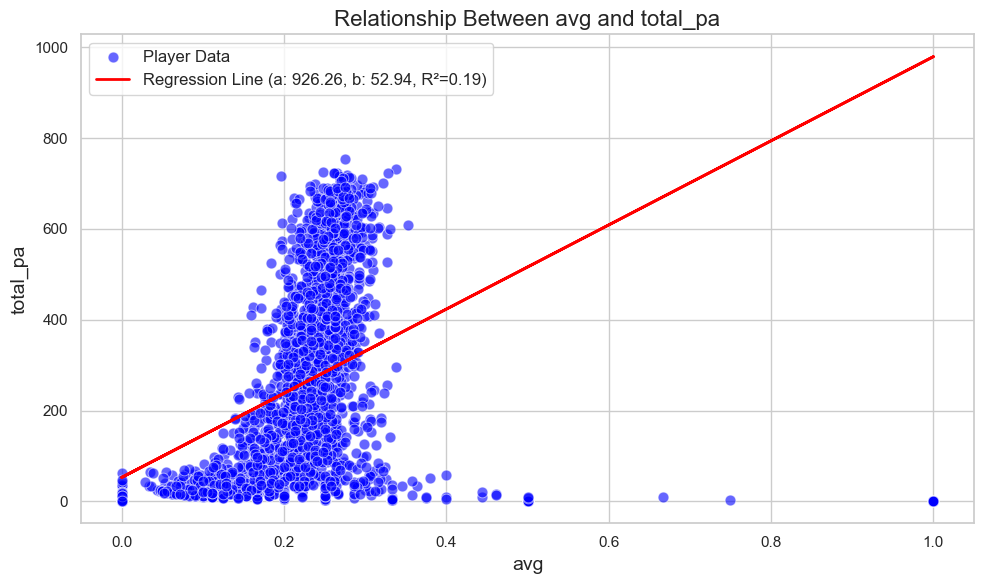

In [148]:
#examples of scatter plots
linear_regression_scatter(df_players_full,'avg','total_pa')

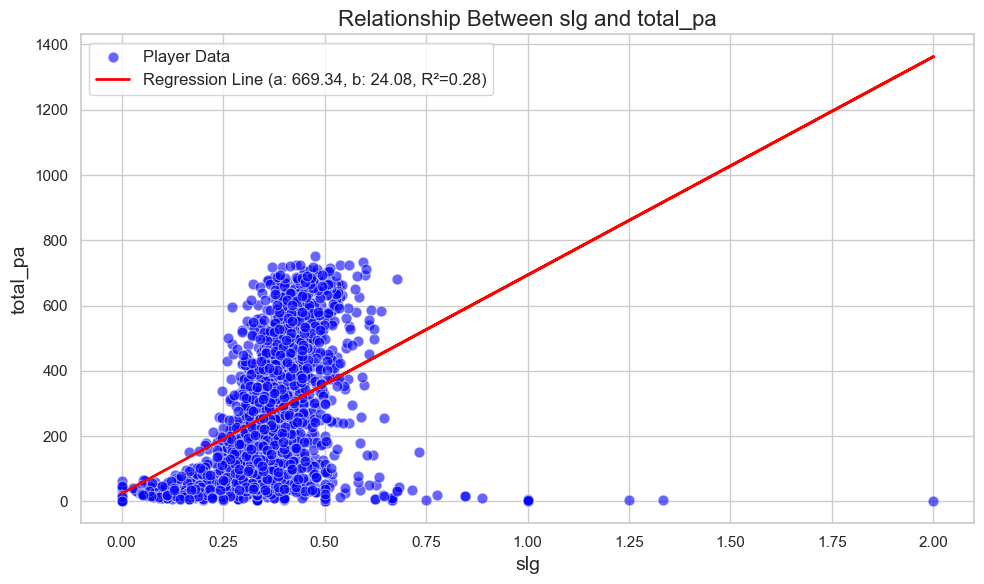

In [150]:
linear_regression_scatter(df_players_full,'slg','total_pa')

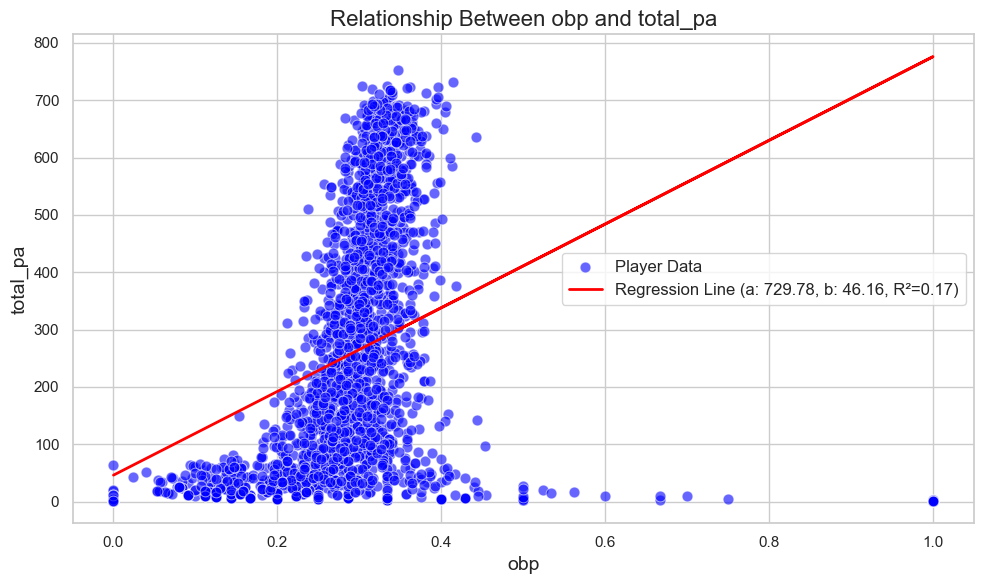

In [152]:
linear_regression_scatter(df_players_full,'obp','total_pa')

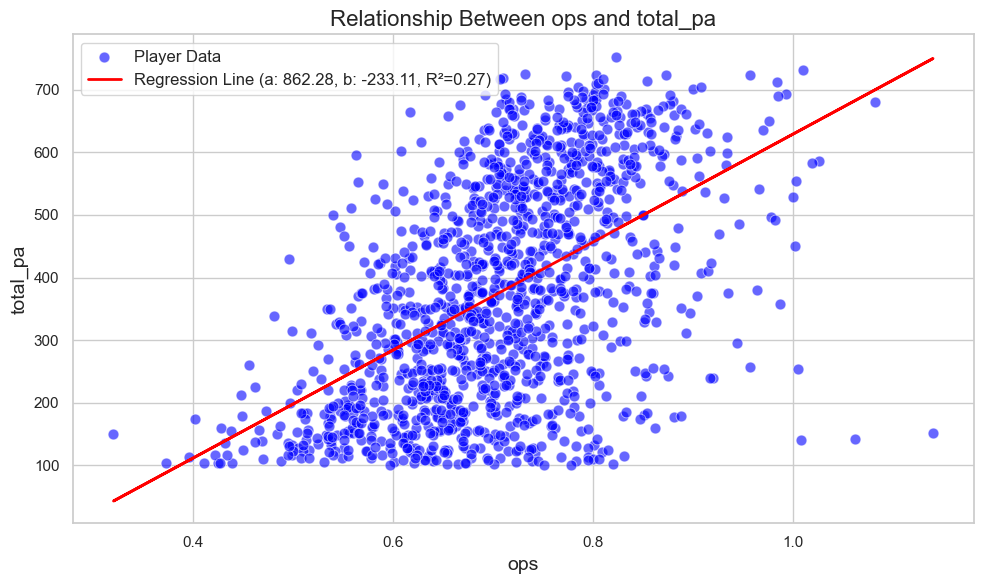

In [154]:
linear_regression_scatter(df_players_full,'ops','total_pa', min_y=100)

In [156]:
#full list of all columns in df_players
for i in df_players_full.columns:
    print(i + ',')

player_mlb_id,
playerID_LAHMAN,
birthYear,
birthMonth,
birthDay,
birthCountry,
weight,
height,
bats,
throws,
debut,
birthDate,
year,
years_after_debut,
total_pa,
total_bf,
base_ended_inn,
field_p,
field_c,
field_1b,
field_2b,
field_3b,
field_ss,
field_lf,
field_cf,
field_rf,
batter_strikeout,
pitcher_strikeout,
batter_caught_stealing_3b,
pitcher_caught_stealing_3b,
batter_field_out,
pitcher_field_out,
batter_walk,
pitcher_walk,
batter_force_out,
pitcher_force_out,
batter_sac_fly,
pitcher_sac_fly,
batter_single,
pitcher_single,
batter_hit_by_pitch,
pitcher_hit_by_pitch,
batter_double,
pitcher_double,
batter_grounded_into_double_play,
pitcher_grounded_into_double_play,
batter_sac_bunt,
pitcher_sac_bunt,
batter_home_run,
pitcher_home_run,
batter_fielders_choice,
pitcher_fielders_choice,
batter_field_error,
pitcher_field_error,
batter_other_out,
pitcher_other_out,
batter_caught_stealing_2b,
pitcher_caught_stealing_2b,
batter_triple,
pitcher_triple,
batter_strikeout_double_play,
pitcher_str

IN PROGRESS: start looking at pitching information

In [158]:
df_savant.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'batter', 'pitcher', 'events', 'description', 'zone',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'fielder_2',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher_1',
       'fielder_2_1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
       'woba_value', 'woba_denom', 'babip_value', 'iso_value',
       'launch_speed_angle', 'at_bat_number', 'pitch_number

In [160]:
#see pitch run 
df_savant.groupby(['pitcher','year','pitch_type'])[['pfx_x','pfx_z']].mean().reset_index()

,pitcher,year,pitch_type,pfx_x,pfx_z
0,007d7209f1d3287648e11f52c5a5148732f7a791,2021,CU,0.169608,-1.089020
1,007d7209f1d3287648e11f52c5a5148732f7a791,2021,FC,0.290000,1.200000
2,007d7209f1d3287648e11f52c5a5148732f7a791,2021,FF,-0.067248,1.371342
3,007d7209f1d3287648e11f52c5a5148732f7a791,2022,CU,0.233559,-1.095932
4,007d7209f1d3287648e11f52c5a5148732f7a791,2022,FC,1.059412,-0.032941
...,...,...,...,...,...
10713,ffd2fbf22dc9ac7811c1bd9ecf5d5c0392744a18,2021,FF,-0.541481,1.194173
10714,ffd2fbf22dc9ac7811c1bd9ecf5d5c0392744a18,2021,SL,0.040101,0.085081
10715,ffd2fbf22dc9ac7811c1bd9ecf5d5c0392744a18,2022,CH,-1.254326,0.701631
10716,ffd2fbf22dc9ac7811c1bd9ecf5d5c0392744a18,2022,FF,-0.457714,1.172240


In [162]:
all_pitch_types = df_savant['pitch_type'].dropna().unique()

In [ ]:
#for pitch in all_pitch_types:
    

In [ ]:
#find percent of each pitch thrown by each player
#get average x and z run of each pitch